<a href="https://colab.research.google.com/github/TDQA2004-04-03/ML/blob/main/BTL_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Feature Extraction: NN (Full Connection layer CNN)
  - Phân tích độ tác động của từng Feature

2. Models
  - CNN
  - KNN
  - RandomForest
  - SVM

3. Hyperparameter tuning  

4. Evaluation
  - Recall
  - Precision
  - F1 Score

5. Report: Overleaf



- Feature Extraction + CNN: Ngô Kỳ Nam
- KNN + Report: Hà Khởi Nguyên
- RF + Report: Trần Dương Quốc Anh
- SVM + Evaluation (Report): Nguyễn Truyền Tuấn

**Viết giải thích trên notebook**.
  
 ❗ Feature Extraction Deadline: 18/04/2025

 ❗ Coding Deadline: 25/04/2025

 ❗ Report Deadline: 28/04/2025

In [1]:
!pip install gdown

# Gdown from folder dataset: https://drive.google.com/drive/folders/1ZLLahCCrN-LSL5ujmMN_mAhZSvSilkH3?usp=sharing
!gdown --folder  1ZLLahCCrN-LSL5ujmMN_mAhZSvSilkH3

# Gdown from checkpoint file: https://drive.google.com/file/d/1YZrYwoiVyvvNYQHLtaeeGgDMzEe9KrkE/view?usp=sharing
!gdown --id 1YZrYwoiVyvvNYQHLtaeeGgDMzEe9KrkE

Retrieving folder contents
Processing file 11FFmb_l5HGhKt8Y7yC_Qk-6ft62feM6e batches.meta
Processing file 1BBFXcvOwo5RUiOLyh4pNmPdMZONIR2ZD data_batch_1
Processing file 1Uly9dhK2BUq2K4OoGadvpSDrz4RiH-iF data_batch_2
Processing file 1CLYIGjlzOVIRSFloSKSJx1nRVbQ4Uozj data_batch_3
Processing file 1chKj9xZV4iEQP5AHcdMI89ZXR9t8zstt data_batch_4
Processing file 16t2_bfHDeIEP4MpvP_C0WVb48XXIv31l data_batch_5
Processing file 1CD6act4BqPnSu_aDvD_TGBB4L1PswYtl readme.html
Processing file 1GaaisE1cys7bZOlSAupwOOed7DL7Sapv test_batch
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=11FFmb_l5HGhKt8Y7yC_Qk-6ft62feM6e
To: /content/cifar-10-batches-py/batches.meta
100% 158/158 [00:00<00:00, 887kB/s]
Downloading...
From: https://drive.google.com/uc?id=1BBFXcvOwo5RUiOLyh4pNmPdMZONIR2ZD
To: /content/cifar-10-batches-py/data_batch_1
100% 31.0M/31.0M [00:00<00:00, 49.2MB/s]
Downloading...
From: https

### Libraries

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from tqdm import tqdm
import numpy as np
import pickle
import matplotlib.pyplot as plt

### Inspiration from LeNet-5 architecture
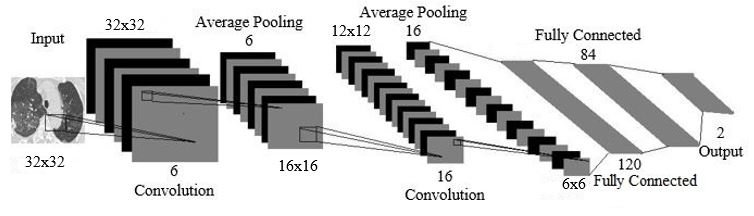

Changes:
- Replace `average pooling` with `max pooling`
- Replace activation function: `tanh` $\rightarrow$ `ReLu`
- Added 1 extra convolution layer
- Number of features extractor is larger: 32 $\rightarrow$ 64 $\rightarrow$ 128

| Layer                     | Activation shape | Activation Size | # Parameters |
|------------------------------------------------------|------------------|------------------|--------------|
| Input                    | (32, 32, 3)      | 3,072            | 0            |
| Conv2d (5x5, 3→32)       | (32, 32, 32)     | 32,768           | 2,432        |
| BatchNorm2d (32)         | (32, 32, 32)     | 32,768           | 64           |
| ReLU                     | (32, 32, 32)     | 32,768           | 0            |
| MaxPool2d (2x2)          | (16, 16, 32)     | 8,192            | 0            |
| Conv2d (5x5, 32→64)      | (12, 12, 64)     | 9,216            | 51,264       |
| BatchNorm2d (64)         | (12, 12, 64)     | 9,216            | 128          |
| ReLU                     | (12, 12, 64)     | 9,216            | 0            |
| Conv2d (3x3, 64→128)     | (12, 12, 128)    | 18,432           | 73,856       |
| BatchNorm2d (128)        | (12, 12, 128)    | 18,432           | 256          |
| ReLU                     | (12, 12, 128)    | 18,432           | 0            |
| MaxPool2d (2x2)          | (6, 6, 128)      | 4,608            | 0            |
| Flatten                  | (4608,)          | 4,608            | 0            |
| Linear (4608 → 1024)     | (1024,)          | 1,024            | 4,719,616    |
| ReLU                     | (1024,)          | 1,024            | 0            |
| Dropout (p=0.5)          | (1024,)          | 1,024            | 0            |
| Linear (1024 → 512)      | (512,)           | 512              | 524,800      |
| ReLU                     | (512,)           | 512              | 0            |
| Dropout (p=0.5)          | (512,)           | 512              | 0            |
| Linear (512 → 256)       | (256,)           | 256              | 131,328      |
| ReLU                     | (256,)           | 256              | 0            |
| Linear (256 → 10)        | (10,)            | 10               | 2,570        |

**Total Parameters: ~5,506,314**

# Our model architecture
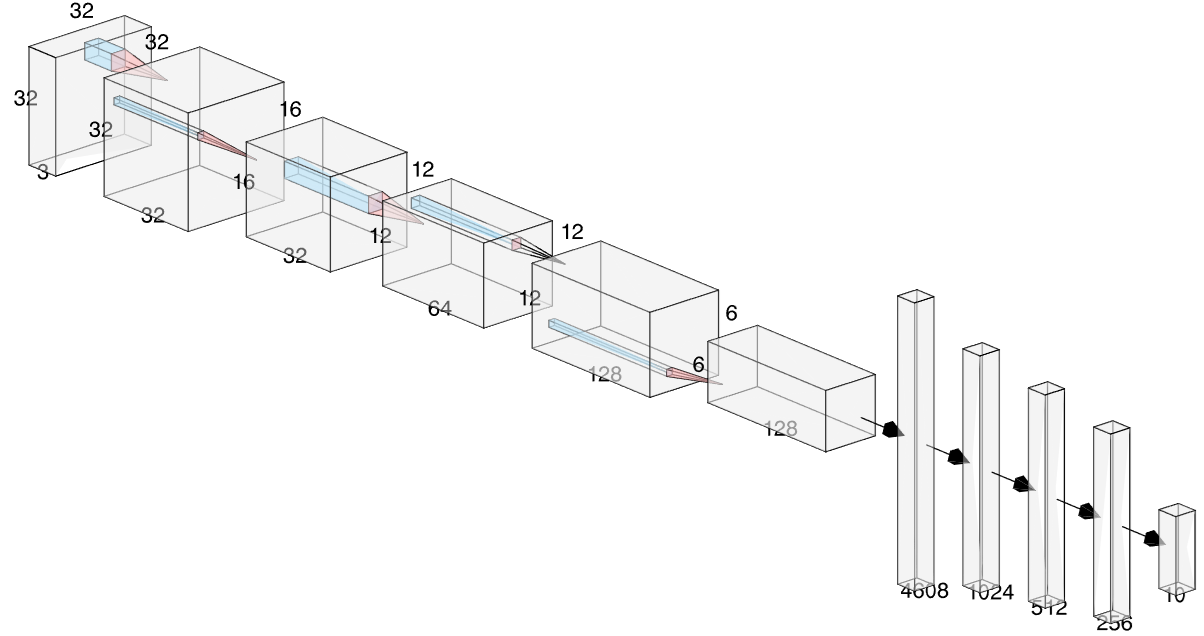

Accuracy: 80.3%, Average loss: 0.654830

# Phải đổi thời gian chạy thành GPU T4

In [3]:
print('Version:',torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'
print(device)
print(device_name)

Version: 2.6.0+cu124
cuda
Tesla T4


In [4]:
data_path = '/content/cifar-10-batches-py/'
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_data(batch_number):
    if batch_number == 'test_batch':
        data = unpickle(data_path + 'test_batch')
    else:
        data = unpickle(data_path + 'data_batch_' + str(batch_number))
    images = data[b'data']
    labels = data[b'labels']
    return images, labels

In [6]:
class CIFAR10Dataset(Dataset):
    def __init__(self, batch_number):
        self.images, self.labels = load_cifar10_data(batch_number)
        self.normalzed_images = self.images.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
        self.labels = np.array(self.labels).astype(np.int64)
        self.img_dir = data_path + 'data_batch_' + str(batch_number) + '/'

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.normalzed_images[idx])
        label = torch.tensor(self.labels[idx])
        return image, label

### DataLoader
Data is loaded in 5 batch $→$ 5 separate loader and dataset
### How to get image from these:
- Index straight from Dataset: `batches[0][0]` → first image of the first batch
- Use data loader: `next(iter(batch_data_loader))` → return a batch of 60 images in the first dataset (like an iterator)

Images are returned as `tensor` object, convert to `numpy_array` using: `img.cpu().numpy()`

In [7]:
batches = []
for i in range(1, 6):
    batches.append(CIFAR10Dataset(i))

batch_data_loaders = []
for i in range(5):
    batch_data_loaders.append(DataLoader(batches[i], batch_size=1, shuffle=True, num_workers=0))

test_batch = CIFAR10Dataset('test_batch')
test_loader = DataLoader(test_batch, batch_size=60, shuffle=True, num_workers=0)

# Convolution and Fully connected layer

In [8]:
convolutional_layers = nn.Sequential(
    # 3x32x32 -> 32x32x32
    nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
    nn.BatchNorm2d(32),  # Add batch normalization
    nn.ReLU(),

    # 32x32x32 -> 32x16x16
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

    # 32x16x16 -> 64x12x12
    nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0),
    nn.BatchNorm2d(64),  # Add batch normalization
    nn.ReLU(),

    # 64x12x12 -> 128x12x12
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),  # Add batch normalization
    nn.ReLU(),

    # 128x12x12 -> 128x6x6
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
)

fully_connected_layers = nn.Sequential(
    # 128x6x6 -> 4608
    nn.Flatten(),

    # 4608 -> 1024
    nn.Linear(4608, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),

    # 1024 -> 512
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(p=0.5),

    # 512 -> 256
    nn.Linear(512, 256),
    nn.ReLU(),

    # 256 -> 10
    nn.Linear(256, 10),
)

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = convolutional_layers
        self.fc_layers = fully_connected_layers

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

### Cách load model và chạy feature extractor
1. Chạy tất cả ô phía trên
2. Phải có file `model1.1.pth`
3. Load model bằng
  ```python
  model = CNN()
  model.load_state_dict(torch.load('/content/model1.1.pth'))
  model.to(device) #chạy nếu có kết nối GPU
  ```
4. Load convolution layer:
  ```python
  conv = model.conv_layers
  ```
5. Chạy
```python
model.eval()
flatten = nn.Flatten()
with torch.no_grad():  
    features = conv(image)
    features = flatten(features).cpu().numpy()
```
- features là một numpy array với 4608 giá trị (xài để train ML model)


# CNN Training

In [ ]:
model = CNN().to(device)
# Start training the model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
num_epochs = 20

In [ ]:
def train_model(model, data_loaders, criterion, optimizer, num_epochs=5):
    model.train()
    for i, dataloader in enumerate(data_loaders, start=1):
        size = len(dataloader.dataset)
        for batch, (X, y) in enumerate(tqdm(dataloader, desc=f"Training batch {i}")):
            X, y = X.to(device), y.to(device) #Move to Cuda

            # Compute prediction and loss
            pred = model(X)
            loss = criterion(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")


"""For use after each epoch"""
def test_model(model, data_loader, criterion):
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += criterion(pred, y).item() #Single element tensor
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_model(model, batch_data_loaders, criterion, optimizer, num_epochs=num_epochs)
    test_model(model, test_loader, criterion)

# KNN

#RF

In [10]:
model = CNN()
model.load_state_dict(torch.load('/content/model1.1.pth'))
model.to(device) #chạy nếu có kết nối GPU

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4608, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
 

In [11]:
conv = model.conv_layers

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [13]:
batches = [CIFAR10Dataset(i) for i in range(1, 6)]
batch_data_loaders = [DataLoader(batches[i],batch_size=1,shuffle=True,num_workers=0) for i in range(5)]

In [18]:
model.eval()
flatten = nn.Flatten()
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
for i, dataloader in enumerate(batch_data_loaders, start=1):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(tqdm(dataloader, desc=f"Training batch {i}")):
        X, y = X.to(device), y.to(device) #Move to Cuda
        print(X)
        print(y)
        break

Training batch 1:   0%|          | 0/10000 [00:00<?, ?it/s]


tensor([[[[1.0000, 1.0000, 1.0000,  ..., 0.9804, 0.7137, 0.5529],
          [0.9961, 0.9922, 0.9961,  ..., 0.7020, 0.4510, 0.5569],
          [1.0000, 0.9922, 0.9961,  ..., 0.5294, 0.4902, 0.7529],
          ...,
          [1.0000, 0.9333, 0.6667,  ..., 0.9961, 0.9922, 0.9961],
          [1.0000, 0.9765, 0.8706,  ..., 0.9961, 0.9922, 0.9961],
          [0.9961, 0.9922, 1.0000,  ..., 0.9961, 0.9922, 0.9961]],

         [[1.0000, 1.0000, 1.0000,  ..., 0.9608, 0.6863, 0.5333],
          [0.9961, 0.9922, 0.9961,  ..., 0.6745, 0.4157, 0.5216],
          [1.0000, 0.9922, 0.9961,  ..., 0.4980, 0.4667, 0.7255],
          ...,
          [1.0000, 0.9294, 0.6471,  ..., 0.9961, 0.9922, 0.9961],
          [1.0000, 0.9804, 0.8745,  ..., 0.9961, 0.9922, 0.9961],
          [0.9961, 0.9922, 1.0000,  ..., 0.9961, 0.9922, 0.9961]],

         [[1.0000, 1.0000, 1.0000,  ..., 0.9490, 0.6549, 0.4824],
          [0.9961, 0.9922, 0.9961,  ..., 0.6314, 0.3686, 0.4706],
          [1.0000, 0.9922, 0.9961,  ..., 0

Training batch 2:   0%|          | 0/10000 [00:00<?, ?it/s]


tensor([[[[0.1647, 0.4471, 0.5373,  ..., 0.4275, 0.2196, 0.2431],
          [0.1569, 0.2980, 0.4118,  ..., 0.4471, 0.3216, 0.3216],
          [0.3922, 0.4627, 0.5020,  ..., 0.2314, 0.4863, 0.5804],
          ...,
          [0.2392, 0.3255, 0.5255,  ..., 0.1804, 0.1569, 0.3608],
          [0.2392, 0.1804, 0.3569,  ..., 0.2863, 0.2471, 0.2902],
          [0.1961, 0.0824, 0.1608,  ..., 0.3490, 0.2118, 0.1882]],

         [[0.2471, 0.5451, 0.6549,  ..., 0.5686, 0.3725, 0.3882],
          [0.2118, 0.3686, 0.4941,  ..., 0.5686, 0.4471, 0.4431],
          [0.4392, 0.5216, 0.5765,  ..., 0.3333, 0.5882, 0.6824],
          ...,
          [0.3882, 0.4902, 0.6824,  ..., 0.2196, 0.2078, 0.4275],
          [0.3647, 0.3255, 0.4980,  ..., 0.3451, 0.3176, 0.3804],
          [0.3098, 0.2078, 0.2863,  ..., 0.4235, 0.3059, 0.2941]],

         [[0.0980, 0.3294, 0.4039,  ..., 0.3333, 0.1176, 0.1961],
          [0.0549, 0.1686, 0.2706,  ..., 0.3412, 0.2157, 0.2667],
          [0.2392, 0.3176, 0.3686,  ..., 0

Training batch 3:   0%|          | 0/10000 [00:00<?, ?it/s]


tensor([[[[0.6588, 0.6745, 0.7020,  ..., 0.6941, 0.6510, 0.6353],
          [0.6784, 0.6941, 0.7176,  ..., 0.7059, 0.6824, 0.6667],
          [0.6824, 0.6980, 0.7176,  ..., 0.7137, 0.6941, 0.6784],
          ...,
          [0.1529, 0.1569, 0.1686,  ..., 0.2392, 0.2078, 0.1765],
          [0.1569, 0.1686, 0.1804,  ..., 0.2039, 0.1725, 0.1451],
          [0.1490, 0.1608, 0.1765,  ..., 0.1373, 0.1216, 0.1333]],

         [[0.6745, 0.6902, 0.7176,  ..., 0.7216, 0.7098, 0.6941],
          [0.6941, 0.7098, 0.7333,  ..., 0.7373, 0.7216, 0.7098],
          [0.6980, 0.7137, 0.7333,  ..., 0.7412, 0.7255, 0.7137],
          ...,
          [0.1882, 0.1922, 0.2039,  ..., 0.2000, 0.1765, 0.1882],
          [0.1922, 0.2039, 0.2157,  ..., 0.1647, 0.1412, 0.1451],
          [0.1843, 0.1961, 0.2118,  ..., 0.1176, 0.0980, 0.1294]],

         [[0.7098, 0.7255, 0.7529,  ..., 0.7804, 0.7608, 0.7451],
          [0.7294, 0.7451, 0.7686,  ..., 0.8000, 0.7843, 0.7686],
          [0.7333, 0.7490, 0.7686,  ..., 0

Training batch 4:   0%|          | 0/10000 [00:00<?, ?it/s]


tensor([[[[0.5569, 0.5216, 0.4431,  ..., 0.4235, 0.4353, 0.4431],
          [0.5961, 0.5255, 0.4863,  ..., 0.4314, 0.4235, 0.3961],
          [0.6078, 0.5843, 0.5412,  ..., 0.4627, 0.4275, 0.3608],
          ...,
          [0.8824, 0.8980, 0.8863,  ..., 0.9373, 0.9569, 0.9608],
          [0.8980, 0.9333, 0.9294,  ..., 0.9490, 0.9569, 0.9608],
          [0.9412, 0.9647, 0.9686,  ..., 0.9490, 0.9451, 0.9529]],

         [[0.5765, 0.5294, 0.4667,  ..., 0.4353, 0.4510, 0.4549],
          [0.6118, 0.5294, 0.4863,  ..., 0.4431, 0.4353, 0.4078],
          [0.6196, 0.5882, 0.5176,  ..., 0.4784, 0.4431, 0.3725],
          ...,
          [0.8745, 0.8902, 0.8745,  ..., 0.9373, 0.9529, 0.9608],
          [0.8941, 0.9294, 0.9255,  ..., 0.9451, 0.9529, 0.9569],
          [0.9373, 0.9608, 0.9647,  ..., 0.9490, 0.9412, 0.9490]],

         [[0.4902, 0.4314, 0.3725,  ..., 0.4000, 0.4157, 0.4157],
          [0.5020, 0.4078, 0.3804,  ..., 0.4000, 0.3922, 0.3647],
          [0.4824, 0.4392, 0.3922,  ..., 0

Training batch 5:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor([[[[0.1059, 0.1765, 0.3765,  ..., 0.6980, 0.9725, 0.9765],
          [0.3451, 0.5490, 0.5725,  ..., 0.8392, 0.8431, 0.9137],
          [0.3373, 0.5098, 0.5804,  ..., 0.4784, 0.3451, 0.4588],
          ...,
          [0.2392, 0.3333, 0.3490,  ..., 0.2196, 0.2549, 0.2745],
          [0.2314, 0.3255, 0.3451,  ..., 0.1922, 0.2314, 0.2510],
          [0.2471, 0.2863, 0.3255,  ..., 0.1647, 0.2078, 0.2235]],

         [[0.1333, 0.1961, 0.3843,  ..., 0.7020, 0.9725, 0.9765],
          [0.3686, 0.5608, 0.5765,  ..., 0.8431, 0.8392, 0.9137],
          [0.3490, 0.5137, 0.5765,  ..., 0.4706, 0.3373, 0.4588],
          ...,
          [0.2000, 0.2941, 0.3098,  ..., 0.2118, 0.2353, 0.2353],
          [0.1882, 0.2863, 0.3059,  ..., 0.1843, 0.2118, 0.2157],
          [0.2118, 0.2549, 0.2941,  ..., 0.1608, 0.1843, 0.1843]],

         [[0.0667, 0.1255, 0.3451,  ..., 0.6863, 0.9765, 0.9804],
          [0.3137, 0.5098, 0.5451,  ..., 0.8275, 0.8431, 0.9098],
          [0.3176, 0.4863, 0.5529,  ..., 0

# SVM

In [ ]:
model = CNN()
model.load_state_dict(torch.load('/content/model1.1.pth'))
model.to(device) #chạy nếu có kết nối GPU

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4608, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
 

In [ ]:
conv = model.conv_layers